In [1]:
# temp time check - remove before submission
import datetime
begin_time = datetime.datetime.now()

# Home Credit Default Risk (HCDR)

Following file contains the course project "Identifying Home Credit Application Default Risk". The data has been extracted from [Home Credit Default Risk (HCDR)  Kaggle Competition](https://www.kaggle.com/c/home-credit-default-risk/). The goal of this project is to predict whether or not a client will repay a loan. In order to make sure that people who struggle to get loans due to insufficient or non-existent credit histories have a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.


## Some of the challenges

* Dataset size 
   * (688 meg uncompressed) with millions of rows of data
   * 2.71 Gig of data uncompressed
* Dealing with missing data
* Imbalanced datasets
* Summarizing transaction data

# Background on Home Credit Group & the Data Load

## Back ground Home Credit Group

Many people struggle to get loans due to insufficient or non-existent credit histories. Unfortunately, this population is often taken advantage of by untrustworthy lenders.

### Home Credit Group

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## Background on the dataset
Home Credit is a non-banking financial institution, founded in 1997 in the Czech Republic.

The company operates in 14 countries (including United States, Russia, Kazahstan, Belarus, China, India) and focuses on lending primarily to people with little or no credit history which will either not obtain loans or became victims of untrustworthly lenders.

Home Credit group has over 29 million customers, total assests of 21 billions Euro, over 160 millions loans, with the majority in Asia and and almost half of them in China (as of 19-05-2018).

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## Data files overview
There are 7 different sources of data:

* __application_train/application_test:__ the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating __0: the loan was repaid__ or __1: the loan was not repaid__. The target variable defines if the client had payment difficulties meaning he/she had late payment more than X days on at least one of the first Y installments of the loan. Such case is marked as 1 while other all other cases as 0.
* __bureau:__ data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* __bureau_balance:__ monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* __previous_application:__ previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
* __POS_CASH_balance:__ monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* __installments_payment:__ payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.
* __credit_card_balance:__ monthly balance of client's previous credit card loans in Home Credit.

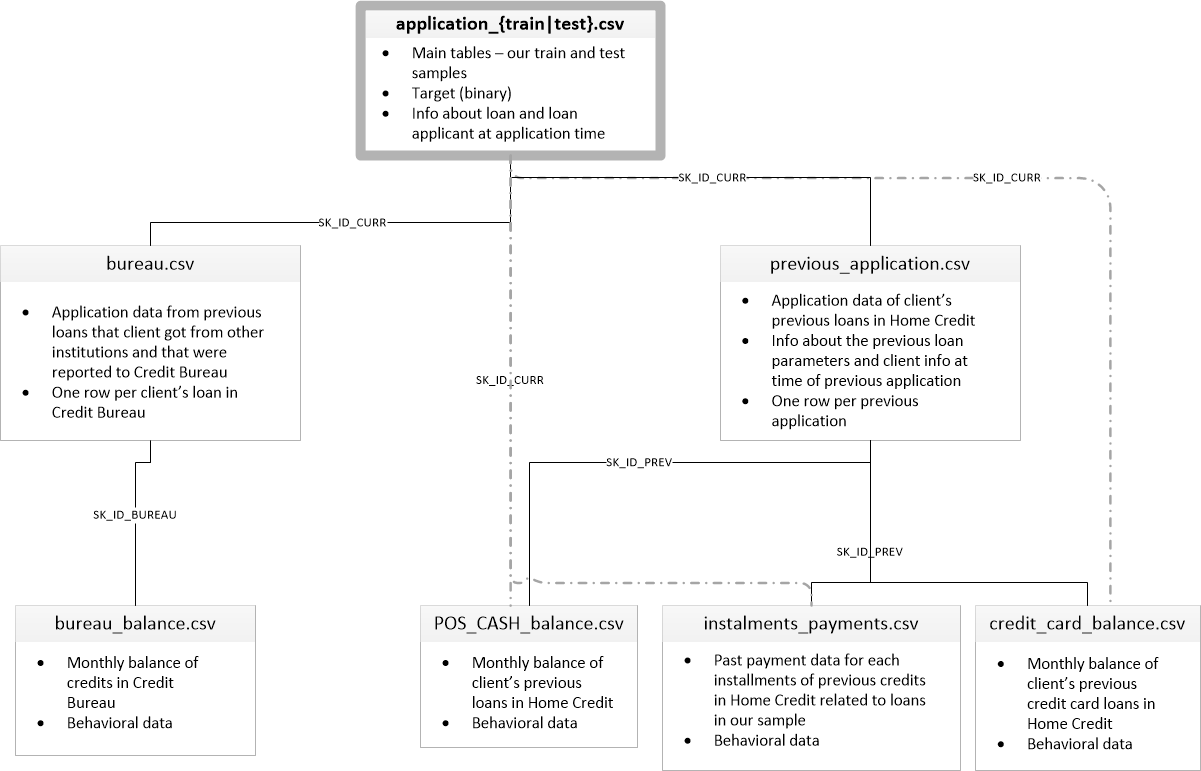

## Set Up


### Environment configuration

In [2]:
# !pip install scikit-optimize

# data manipulation
import numpy as np
import pandas as pd 

import os
import zipfile

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# splitting
from sklearn.model_selection import train_test_split

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder

# pipelines
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# tuning
from sklearn.model_selection import GridSearchCV, cross_val_score
from skopt import BayesSearchCV

# model evaluation
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, plot_confusion_matrix

### Global options

In [3]:
# do not show warnings
import warnings
warnings.filterwarnings('ignore')

# set pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Directories

In [4]:
# set the data directory
DATA_DIR = "../data/home-credit-default-risk"  # data folder will be present in the level as the code folder

# set the directory for storing model objects
MODEL_DIR = "../output/models"

# set the results folder for storing model results
REPORT_DIR = "../output/reports"

### Functions

In [5]:
# define a function for loading in dataset
def load_data(in_path, name):
    df = pd.read_csv(in_path)
    print(f"{name}: shape is {df.shape}")
    print(df.info())
    display(df.head(5))
    return df

datasets={}  # data will be stored in a dictionary

In [6]:
# create aggregate features
class FeaturesAggregater(BaseEstimator, TransformerMixin):
    def __init__(self, grouping_feature = None, features=None, stats = [
#         "min", "max", "mean", "std",
        "median"]):
        self.features = features
        self.grouping_feature = grouping_feature
        self.stats = [
#             "min", "max", "mean", "std",
            "median"]
        self.agg_op_features = {}
        self.agg_features_names = [self.grouping_feature]
        for f in features:
            self.agg_op_features[f] = self.stats
            self.agg_features_names = self.agg_features_names + [f + "_" + s for s in stats]
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        result = X.groupby(self.grouping_feature).agg(self.agg_op_features)
        result.columns = result.columns.droplevel()
        result = result.reset_index(level=[self.grouping_feature])
        result.columns = self.agg_features_names
        return result

### Data Load

In [7]:
%%time

datasets={}  # data will be stored in a dictionary

# set the dataset names
ds_names = ("application_train", "application_test", "bureau","bureau_balance","credit_card_balance","installments_payments",
            "previous_application","POS_CASH_balance")

# read in datasets and print first few records
for ds_name in ds_names:
    datasets[ds_name] = load_data(os.path.join(DATA_DIR, f'{ds_name}.csv'), ds_name)

application_train: shape is (307511, 122)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

application_test: shape is (48744, 121)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB
None


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

bureau: shape is (1716428, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
None


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


bureau_balance: shape is (27299925, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB
None


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


credit_card_balance: shape is (3840312, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_C

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


installments_payments: shape is (13605401, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB
None


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


previous_application: shape is (1670214, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 1

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


POS_CASH_balance: shape is (10001358, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB
None


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


CPU times: user 29.2 s, sys: 3.56 s, total: 32.8 s
Wall time: 43.6 s


In [8]:
# print data shape
for ds_name in datasets.keys():
    print(f'dataset {ds_name:24}: [ {datasets[ds_name].shape[0]:10,}, {datasets[ds_name].shape[1]}]')


dataset application_train       : [    307,511, 122]
dataset application_test        : [     48,744, 121]
dataset bureau                  : [  1,716,428, 17]
dataset bureau_balance          : [ 27,299,925, 3]
dataset credit_card_balance     : [  3,840,312, 23]
dataset installments_payments   : [ 13,605,401, 8]
dataset previous_application    : [  1,670,214, 37]
dataset POS_CASH_balance        : [ 10,001,358, 8]


### Contents to DF and Cleanup

In [9]:
appTrainDF = datasets["application_train"]
appTestDF = datasets["application_test"]
bureauDF = datasets["bureau"]
bureauBalDF = datasets["bureau_balance"]
creditCardBalDF = datasets["credit_card_balance"]
installmentPayDF = datasets["installments_payments"]
previousAppDF = datasets["previous_application"]
cashBalDF = datasets["POS_CASH_balance"]

In [10]:
# delete objects no longer needed for memory
import gc
gc.enable()
del datasets
gc.collect()

66

# EDA

## Application Datasets - Exploration

In [11]:
appTrainDF.describe() #numerical only features

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [12]:
appTestDF.describe() #numerical only features

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,16432.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,28212.000000,48736.000000,40076.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,24857.000000,21103.000000,25888.000000,16926.000000,15249.000000,23555.000000,25165.000000,25423.000000,16278.000000,20490.000000,15964.000000,25192.000000,15397.000000,22660.000000,26120.000000,48715.000000,48715.000000,48715.000000,48715.000000,48744.000000,48744.0,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.000000,48744.0,48744.000000,48744.0,48744.0,48744.0,48744.0,48744.0,48744.0,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,-3051.712949,11.786027,0.999979,0.809720,0.204702,0.998400,0.263130,0.162646,2.146767,2.038159,2.012596,12.007365,0.018833,0.055166,0.042036,0.077466,0.224664,0.174216,0.501180,0.518021,0.500106,0.122388,0.090065,0.978828,0.751137,0.047624,0.085168,0.151777,0.233706,0.238423,0.067192,0.105885,0.112286,0.009231,0.029387,0.119078,0.088998,0.978292,0.758327,0.045223,0.080570,0.147161,0.229390,0.233854,0.065914,0.110874,0.110687,0.008358,0.028161,0.122809,0.089529,0.978822,0.754344,0.047420,0.084128,0.151200,0.233154,0.237846,0.068069,0.107063,0.113368,0.008979,0.029296,0.107129,1.447644,0.143652,1.435738,0.101139,-1077.766228,0.0,0.786620,

In [13]:
appTrainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [14]:
appTestDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


### Unique Values in Columns with Object Type

In [15]:
appTrainDF.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [16]:
appTestDF.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64


No anomaly in terms of unique values present in Test set but not in Train set. 

This information is also useful in determining the needed encoding for categorical values.

### Missing Data

In [17]:
percent = (appTrainDF.isnull().sum()/appTrainDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = appTrainDF.isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Train Missing Count"])
missing_application_train_data.head(20)

,Percent,Train Missing Count
COMMONAREA_MEDI,69.87,214865
COMMONAREA_AVG,69.87,214865
COMMONAREA_MODE,69.87,214865
NONLIVINGAPARTMENTS_MODE,69.43,213514
NONLIVINGAPARTMENTS_AVG,69.43,213514
NONLIVINGAPARTMENTS_MEDI,69.43,213514
FONDKAPREMONT_MODE,68.39,210295
LIVINGAPARTMENTS_MODE,68.35,210199
LIVINGAPARTMENTS_AVG,68.35,210199
LIVINGAPARTMENTS_MEDI,68.35,210199


There are no columns with more than 70% of the data missing. 17 columns have missing data for more than 60% of the records.

In [18]:
percent = (appTestDF.isnull().sum()/appTestDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = appTestDF.isna().sum().sort_values(ascending = False)
missing_application_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Test Missing Count"])
missing_application_train_data.head(20)

,Percent,Test Missing Count
COMMONAREA_AVG,68.72,33495
COMMONAREA_MODE,68.72,33495
COMMONAREA_MEDI,68.72,33495
NONLIVINGAPARTMENTS_AVG,68.41,33347
NONLIVINGAPARTMENTS_MODE,68.41,33347
NONLIVINGAPARTMENTS_MEDI,68.41,33347
FONDKAPREMONT_MODE,67.28,32797
LIVINGAPARTMENTS_AVG,67.25,32780
LIVINGAPARTMENTS_MODE,67.25,32780
LIVINGAPARTMENTS_MEDI,67.25,32780


There are no columns with more than 70% of the data missing. 17 columns have missing data for more than 60% of the records.

### Value Distribution in TARGET Column

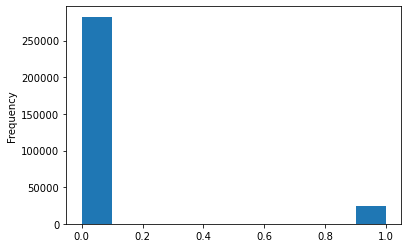

In [19]:
appTrainDF['TARGET'].astype(int).plot.hist();

Value of 0 in the TARGET column indicates that the loan has been repaid, whereas the value of 1 indicates that the loan has not been repaid. From the above chart we can see that there is an imbalance in the distribution of class (TARGET) values, wherein the percentage of records in the Train dataset is very less for the loan non-repay compared to loan repaid.

### Correlation with the TARGET column 

In [20]:
correlations = appTrainDF.corr()['TARGET'].sort_values()

print('Most Positive Correlations with TARGET - Top 10:')
print(correlations.tail(10))

print('\nMost Negative Correlations with TARGET - Top 10:')
print(correlations.head(10))

Most Positive Correlations with TARGET - Top 10:
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations with TARGET - Top 10:
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
REGION_POPULATION_RELATIVE   -0.037227
ELEVATORS_AVG                -0.034199
Name: TARGET, dtype: float64


### Age of the Applicants

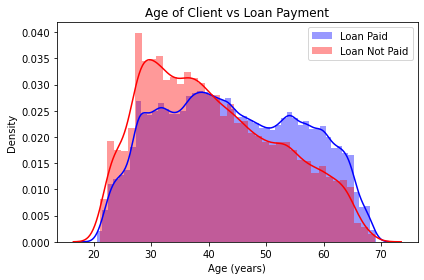

In [21]:
plt.figure()
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 0, 'DAYS_BIRTH'] / -365, hist=True, color='blue', label = 'Loan Paid')
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 1, 'DAYS_BIRTH'] / -365, hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Age of Client vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

### Credit Amount of the Applicants

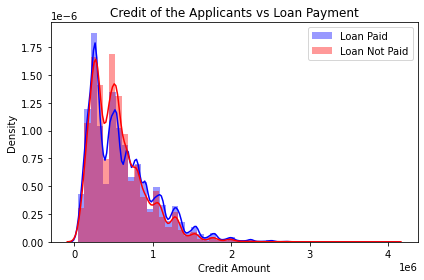

In [22]:
plt.figure()
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 0, 'AMT_CREDIT'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 1, 'AMT_CREDIT'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Credit of the Applicants vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

### Normalized Score from External Source 1

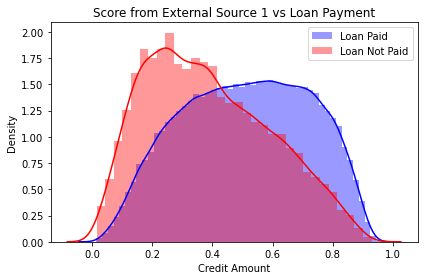

In [23]:
plt.figure()
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 0, 'EXT_SOURCE_1'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 1, 'EXT_SOURCE_1'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Score from External Source 1 vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

### Normalized Score from External Source 2

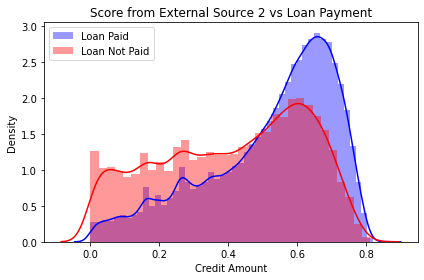

In [24]:
plt.figure()
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 0, 'EXT_SOURCE_2'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 1, 'EXT_SOURCE_2'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Score from External Source 2 vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

### Normalized Score from External Source 3

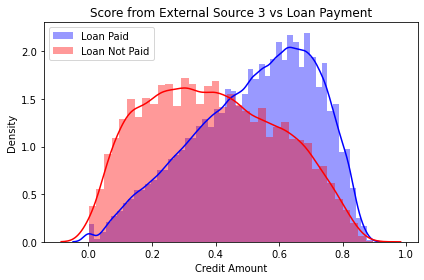

In [25]:
plt.figure()
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 0, 'EXT_SOURCE_3'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 1, 'EXT_SOURCE_3'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Score from External Source 3 vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

### Region Rating Client

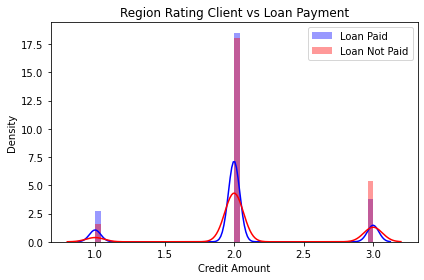

In [26]:
plt.figure()
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 0, 'REGION_RATING_CLIENT'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 1, 'REGION_RATING_CLIENT'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Region Rating Client vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

### Region Rating Client with City

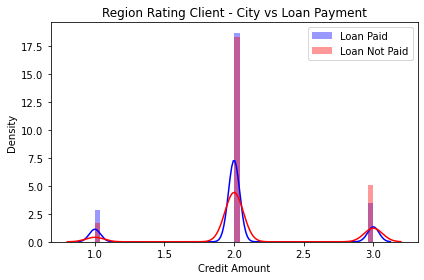

In [27]:
plt.figure()
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 0, 'REGION_RATING_CLIENT_W_CITY'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 1, 'REGION_RATING_CLIENT_W_CITY'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Region Rating Client - City vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

### Information About Building where Client Lives

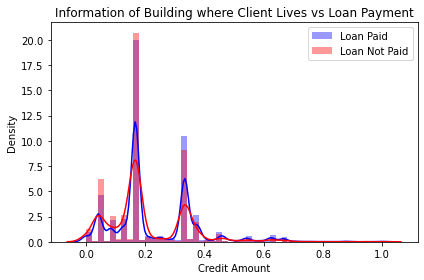

In [28]:
plt.figure()
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 0, 'FLOORSMAX_AVG'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(appTrainDF.loc[appTrainDF['TARGET'] == 1, 'FLOORSMAX_AVG'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Information of Building where Client Lives vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

### Occupation of the Applicants

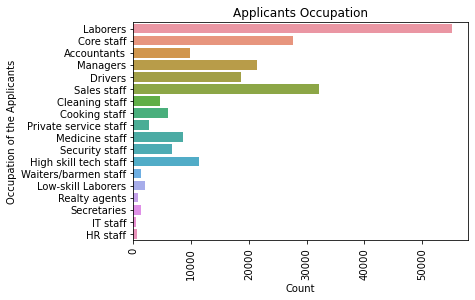

In [29]:
sns.countplot(y='OCCUPATION_TYPE', data=appTrainDF)
plt.title('Applicants Occupation')
plt.ylabel("Occupation of the Applicants")
plt.xlabel("Count")
plt.xticks(rotation=90);

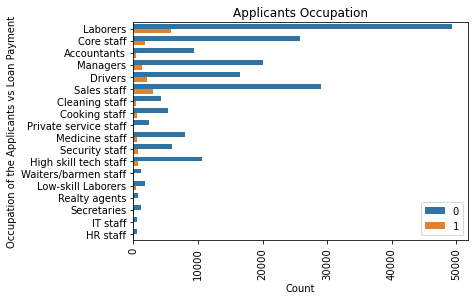

In [30]:
sns.countplot(y='OCCUPATION_TYPE', data=appTrainDF, hue='TARGET')
plt.title('Applicants Occupation')
plt.ylabel("Occupation of the Applicants vs Loan Payment")
plt.xlabel("Count")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show();

### Income Source for the Applicants

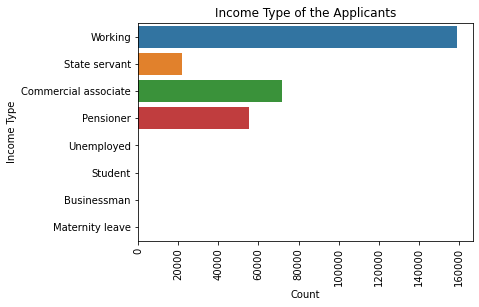

In [31]:
sns.countplot(y='NAME_INCOME_TYPE', data=appTrainDF)
plt.title('Income Type of the Applicants')
plt.ylabel("Income Type")
plt.xlabel("Count")
plt.xticks(rotation=90);

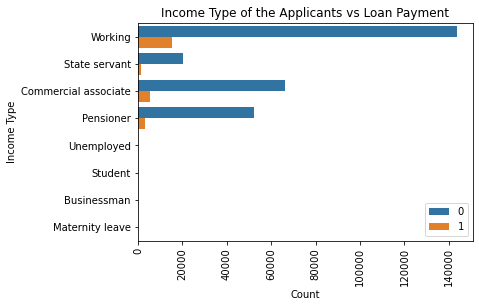

In [32]:
sns.countplot(y='NAME_INCOME_TYPE', data=appTrainDF, hue='TARGET')
plt.title('Income Type of the Applicants vs Loan Payment')
plt.ylabel("Income Type")
plt.xlabel("Count")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show();

### Education of the Applicants

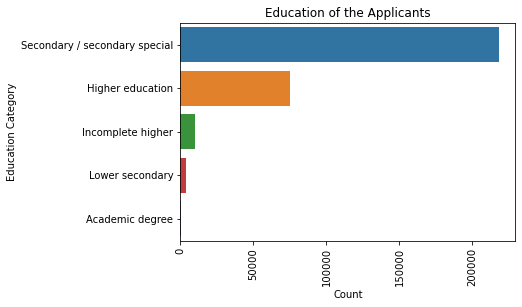

In [33]:
sns.countplot(y='NAME_EDUCATION_TYPE', data=appTrainDF)
plt.title('Education of the Applicants')
plt.ylabel("Education Category")
plt.xlabel("Count")
plt.xticks(rotation=90);

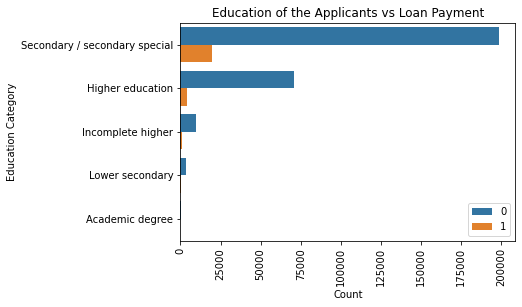

In [34]:
sns.countplot(y='NAME_EDUCATION_TYPE', data=appTrainDF, hue='TARGET')
plt.title('Education of the Applicants vs Loan Payment')
plt.ylabel("Education Category")
plt.xlabel("Count")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show();

### Housing Type of the Applicants

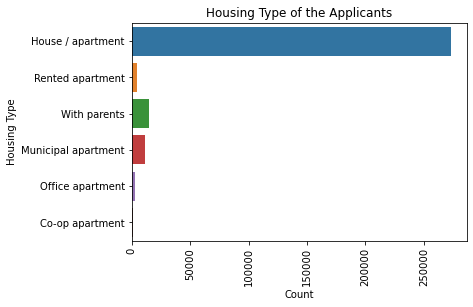

In [35]:
sns.countplot(y='NAME_HOUSING_TYPE', data=appTrainDF)
plt.title('Housing Type of the Applicants')
plt.ylabel("Housing Type")
plt.xlabel("Count")
plt.xticks(rotation=90);

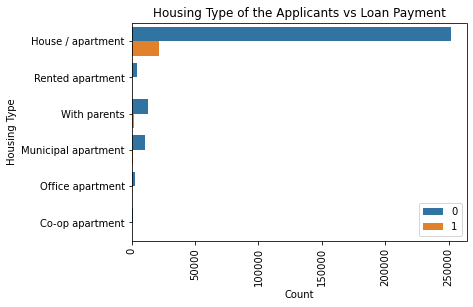

In [36]:
sns.countplot(y='NAME_HOUSING_TYPE', data=appTrainDF, hue='TARGET')
plt.title('Housing Type of the Applicants vs Loan Payment')
plt.ylabel("Housing Type")
plt.xlabel("Count")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show();

### Family Status of the Applicants

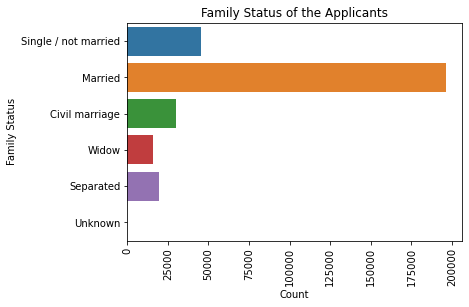

In [37]:
sns.countplot(y='NAME_FAMILY_STATUS', data=appTrainDF)
plt.title('Family Status of the Applicants')
plt.ylabel("Family Status")
plt.xlabel("Count")
plt.xticks(rotation=90);

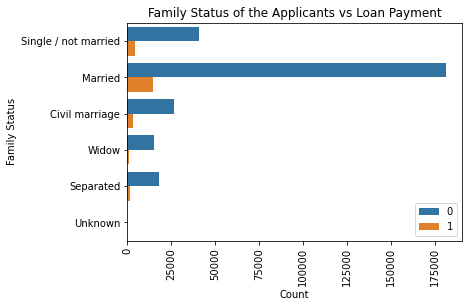

In [38]:
sns.countplot(y='NAME_FAMILY_STATUS', data=appTrainDF, hue='TARGET')
plt.title('Family Status of the Applicants vs Loan Payment')
plt.ylabel("Family Status")
plt.xlabel("Count")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show();

### Members Accompanying Clients

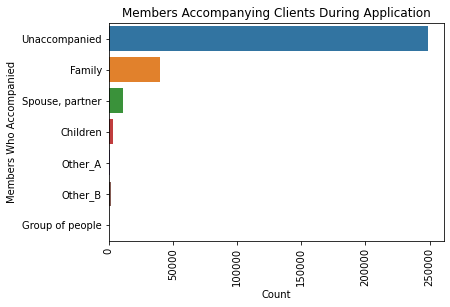

In [39]:
sns.countplot(y='NAME_TYPE_SUITE', data=appTrainDF)
plt.title('Members Accompanying Clients During Application')
plt.ylabel("Members Who Accompanied")
plt.xlabel("Count")
plt.xticks(rotation=90);

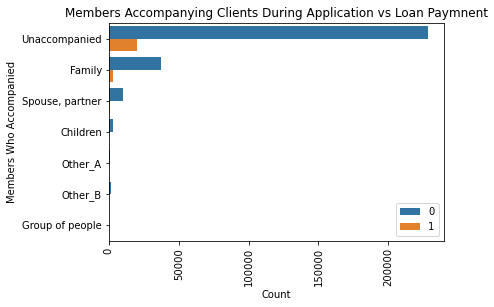

In [40]:
sns.countplot(y='NAME_TYPE_SUITE', data=appTrainDF, hue='TARGET')
plt.title('Members Accompanying Clients During Application vs Loan Paymnent')
plt.ylabel("Members Who Accompanied")
plt.xlabel("Count")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show();

### Organization Type Applying for Loan

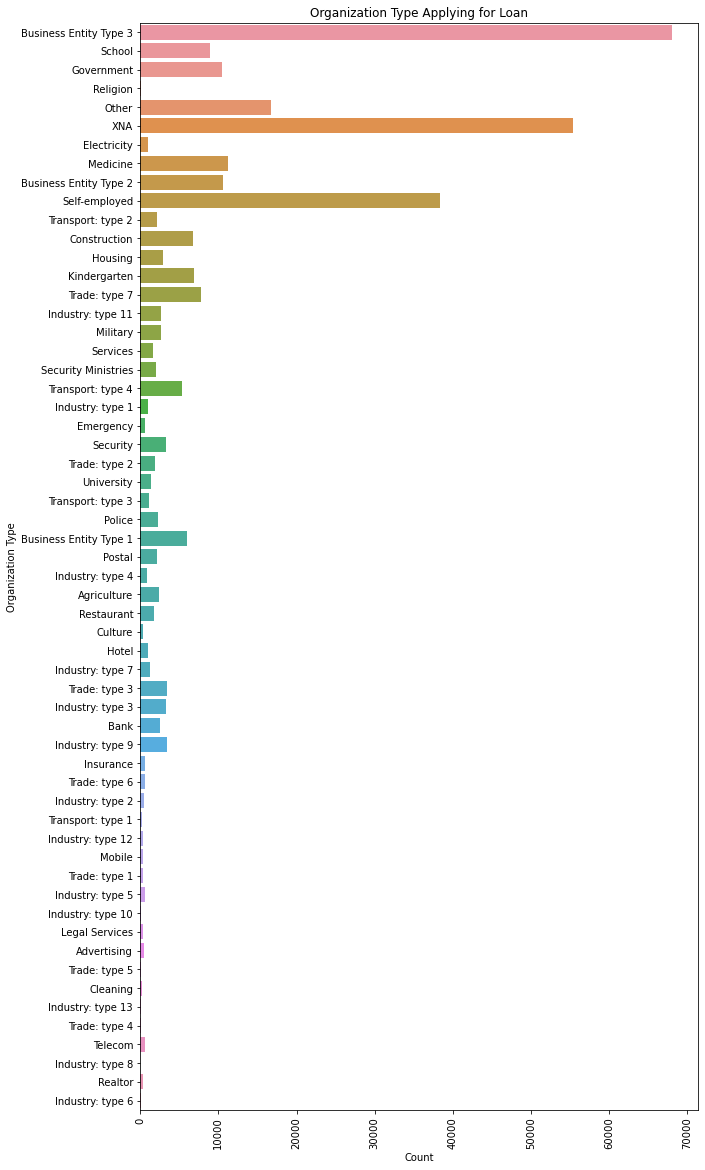

In [41]:
plt.figure(figsize=(10, 20))
sns.countplot(y='ORGANIZATION_TYPE', data=appTrainDF)
plt.title('Organization Type Applying for Loan')
plt.ylabel("Organization Type")
plt.xlabel("Count")
plt.xticks(rotation=90);

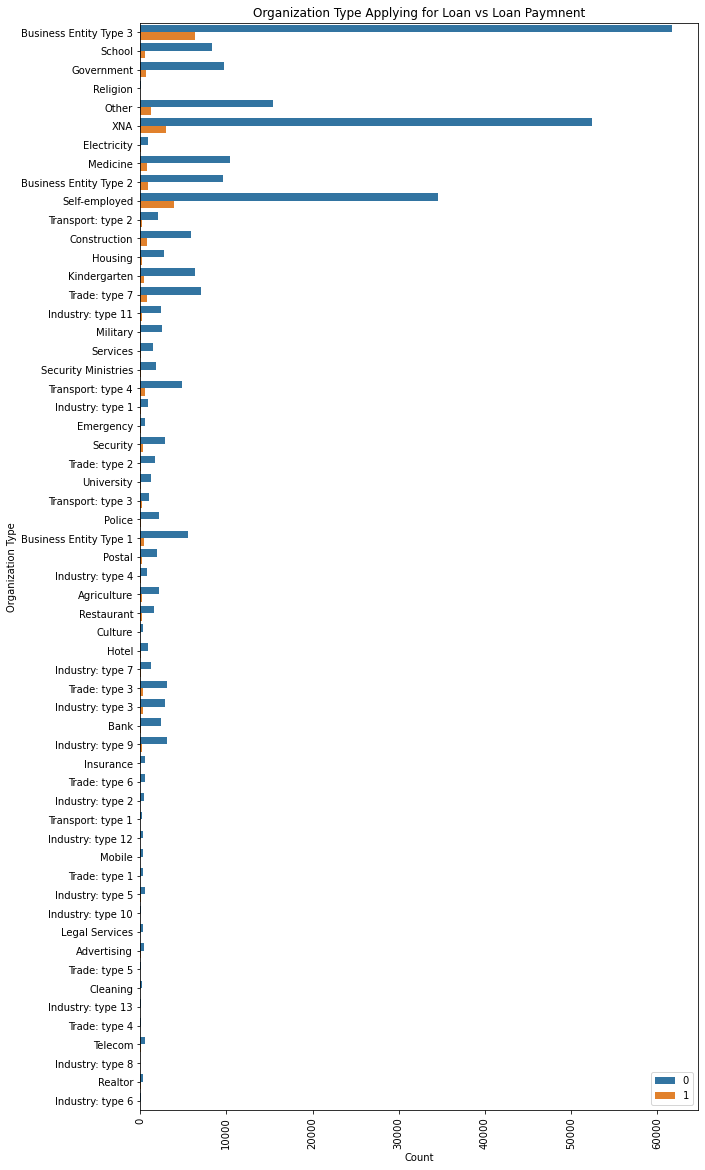

In [42]:
plt.figure(figsize=(10, 20))
sns.countplot(y='ORGANIZATION_TYPE', data=appTrainDF, hue='TARGET')
plt.title('Organization Type Applying for Loan vs Loan Paymnent')
plt.ylabel("Organization Type")
plt.xlabel("Count")
plt.xticks(rotation=90)
plt.legend(loc='lower right')
plt.show();

## Previous Application Dataset - Exploration

In [43]:
previousAppDF.describe() #numerical only features

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,0.188357,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,0.087671,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,0.160716,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,0.189122,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,0.193330,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [44]:
previousAppDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

### Unique Values in Columns with Object Type

In [45]:
previousAppDF.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE              4
WEEKDAY_APPR_PROCESS_START      7
FLAG_LAST_APPL_PER_CONTRACT     2
NAME_CASH_LOAN_PURPOSE         25
NAME_CONTRACT_STATUS            4
NAME_PAYMENT_TYPE               4
CODE_REJECT_REASON              9
NAME_TYPE_SUITE                 7
NAME_CLIENT_TYPE                4
NAME_GOODS_CATEGORY            28
NAME_PORTFOLIO                  5
NAME_PRODUCT_TYPE               3
CHANNEL_TYPE                    8
NAME_SELLER_INDUSTRY           11
NAME_YIELD_GROUP                5
PRODUCT_COMBINATION            17
dtype: int64

### Missing Data

In [46]:
percent = (previousAppDF.isnull().sum()/previousAppDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = previousAppDF.isna().sum().sort_values(ascending = False)
missing_prevapplication_train_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Prev App Missing Count"])
missing_prevapplication_train_data.head(20)

,Percent,Prev App Missing Count
RATE_INTEREST_PRIVILEGED,99.64,1664263
RATE_INTEREST_PRIMARY,99.64,1664263
AMT_DOWN_PAYMENT,53.64,895844
RATE_DOWN_PAYMENT,53.64,895844
NAME_TYPE_SUITE,49.12,820405
NFLAG_INSURED_ON_APPROVAL,40.30,673065
DAYS_TERMINATION,40.30,673065
DAYS_LAST_DUE,40.30,673065
DAYS_LAST_DUE_1ST_VERSION,40.30,673065
DAYS_FIRST_DUE,40.30,673065


2 columns have missing data for over 99% of the records. These columns can be ignored in the model.

### Contract Types in Previous Application

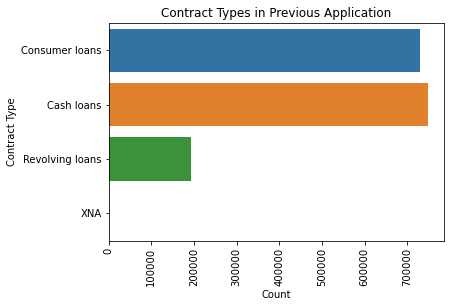

In [47]:
sns.countplot(y='NAME_CONTRACT_TYPE', data=previousAppDF)
plt.title('Contract Types in Previous Application')
plt.ylabel("Contract Type")
plt.xlabel("Count")
plt.xticks(rotation=90);

### Amount Requested in Previous Application & Amount Approved For

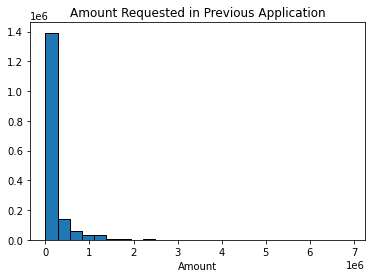

In [48]:
plt.hist(previousAppDF['AMT_APPLICATION'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Amount Requested in Previous Application'); plt.xlabel('Amount'); 

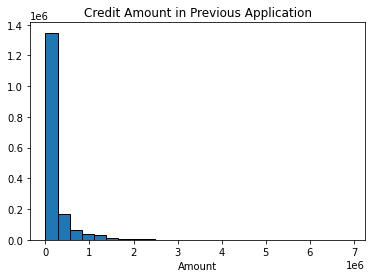

In [49]:
plt.hist(previousAppDF['AMT_CREDIT'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Credit Amount in Previous Application'); plt.xlabel('Amount'); 

### Purpose of Cash Loan in Previous Application

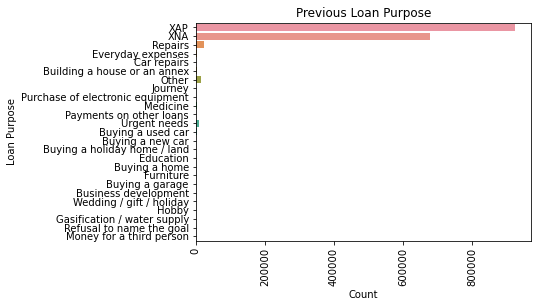

In [50]:
sns.countplot(y='NAME_CASH_LOAN_PURPOSE', data=previousAppDF)
plt.title('Previous Loan Purpose')
plt.ylabel("Loan Purpose")
plt.xlabel("Count")
plt.xticks(rotation=90);

### Contract Status in Previous Application

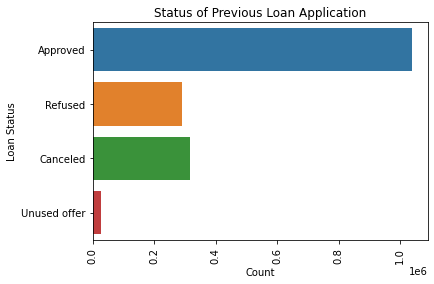

In [51]:
sns.countplot(y='NAME_CONTRACT_STATUS', data=previousAppDF)
plt.title('Status of Previous Loan Application')
plt.ylabel("Loan Status")
plt.xlabel("Count")
plt.xticks(rotation=90);

### Reason for Previous Loan Rejection

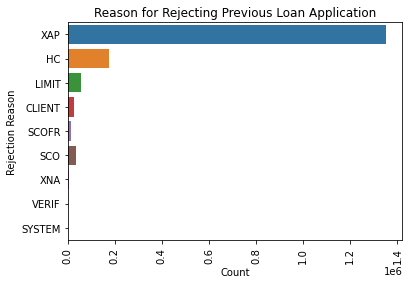

In [52]:
sns.countplot(y='CODE_REJECT_REASON', data=previousAppDF)
plt.title('Reason for Rejecting Previous Loan Application')
plt.ylabel("Rejection Reason")
plt.xlabel("Count")
plt.xticks(rotation=90);

## Credit Card Balance Dataset - Exploration

In [53]:
creditCardBalDF.describe() #numerical only features

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.072324e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,1.028054e+04,7.588857e+03,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,3.607808e+04,3.200599e+04,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.523700e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.702700e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,9.000000e+03,6.750000e+03,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,4.289207e+06,4.278316e+06,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


In [54]:
creditCardBalDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

### Missing Data

In [55]:
percent = (creditCardBalDF.isnull().sum()/creditCardBalDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = creditCardBalDF.isna().sum().sort_values(ascending = False)
missing_creditcardbal_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Credit Card Data Missing Count"])
missing_creditcardbal_data.head(20)

,Percent,Credit Card Data Missing Count
AMT_PAYMENT_CURRENT,20.00,767988
AMT_DRAWINGS_ATM_CURRENT,19.52,749816
CNT_DRAWINGS_POS_CURRENT,19.52,749816
AMT_DRAWINGS_OTHER_CURRENT,19.52,749816
AMT_DRAWINGS_POS_CURRENT,19.52,749816
CNT_DRAWINGS_OTHER_CURRENT,19.52,749816
CNT_DRAWINGS_ATM_CURRENT,19.52,749816
CNT_INSTALMENT_MATURE_CUM,7.95,305236
AMT_INST_MIN_REGULARITY,7.95,305236
SK_ID_PREV,0.00,0


### Contract Status on the Previous Credit

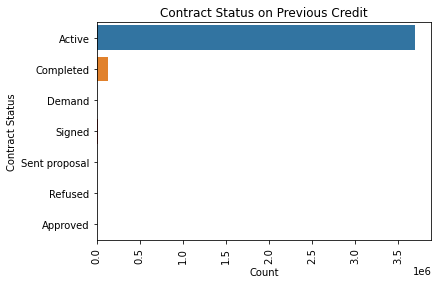

In [56]:
sns.countplot(y='NAME_CONTRACT_STATUS', data=creditCardBalDF)
plt.title('Contract Status on Previous Credit');
plt.ylabel("Contract Status")
plt.xlabel("Count")
plt.xticks(rotation=90);

### Amount Balance on Previous Credit

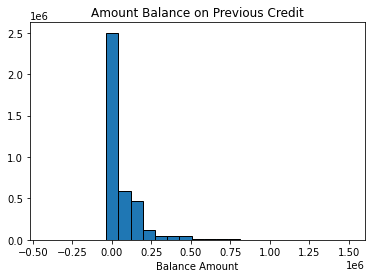

In [57]:
plt.hist(creditCardBalDF['AMT_BALANCE'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Amount Balance on Previous Credit'); plt.xlabel('Balance Amount'); 

### Days Past Due (DPD) During Month on Previous Credit

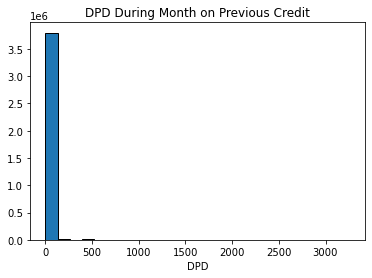

In [58]:
plt.hist(creditCardBalDF['SK_DPD'].dropna(), edgecolor = 'k', bins = 25)
plt.title('DPD During Month on Previous Credit'); plt.xlabel('DPD'); 

### Credit Card Limit on Previous Credit

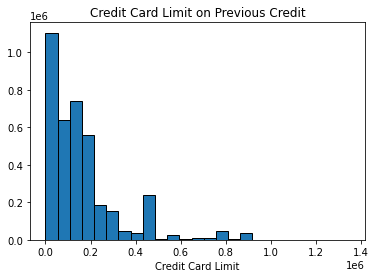

In [59]:
plt.hist(creditCardBalDF['AMT_CREDIT_LIMIT_ACTUAL'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Credit Card Limit on Previous Credit'); plt.xlabel('Credit Card Limit'); 

## Installment Payment Dataset - Exploration

In [60]:
installmentPayDF.describe() #numerical only features

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [61]:
installmentPayDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


### Missing Data

In [62]:
percent = (installmentPayDF.isnull().sum()/installmentPayDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = installmentPayDF.isna().sum().sort_values(ascending = False)
missing_installmentpayment_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Installment Payment Data Missing Count"])
missing_installmentpayment_data.head(20)

,Percent,Installment Payment Data Missing Count
DAYS_ENTRY_PAYMENT,0.02,2905
AMT_PAYMENT,0.02,2905
SK_ID_PREV,0.00,0
SK_ID_CURR,0.00,0
NUM_INSTALMENT_VERSION,0.00,0
NUM_INSTALMENT_NUMBER,0.00,0
DAYS_INSTALMENT,0.00,0
AMT_INSTALMENT,0.00,0


### Prescribed Installment Amount of Previous Credit on this Installment

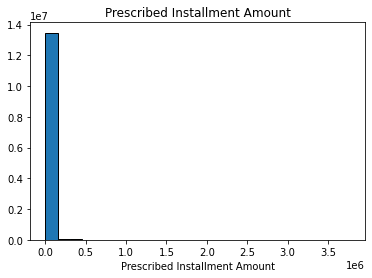

In [63]:
plt.hist(installmentPayDF['AMT_INSTALMENT'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Prescribed Installment Amount'); plt.xlabel('Prescribed Installment Amount'); 

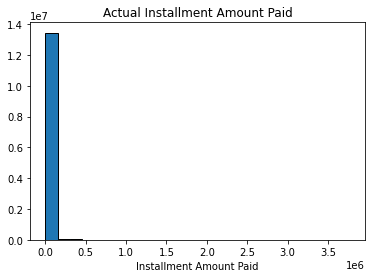

In [64]:
plt.hist(installmentPayDF['AMT_PAYMENT'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Actual Installment Amount Paid'); plt.xlabel('Installment Amount Paid'); 

## POS Cash Balance Dataset - Exploration

In [65]:
cashBalDF.describe() #numerical only features

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [66]:
cashBalDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


### Missing Data

In [67]:
percent = (cashBalDF.isnull().sum()/cashBalDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = cashBalDF.isna().sum().sort_values(ascending = False)
missing_POScashbalance_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "POS Cash Balance Missing Count"])
missing_POScashbalance_data.head(20)

,Percent,POS Cash Balance Missing Count
CNT_INSTALMENT_FUTURE,0.26,26087
CNT_INSTALMENT,0.26,26071
SK_ID_PREV,0.00,0
SK_ID_CURR,0.00,0
MONTHS_BALANCE,0.00,0
NAME_CONTRACT_STATUS,0.00,0
SK_DPD,0.00,0
SK_DPD_DEF,0.00,0


### Installments Left to Pay on Previous Credit

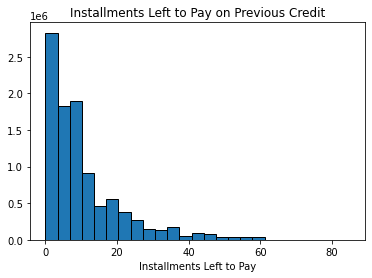

In [68]:
plt.hist(cashBalDF['CNT_INSTALMENT_FUTURE'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Installments Left to Pay on Previous Credit'); plt.xlabel('Installments Left to Pay'); 

### Contract Status During the Month

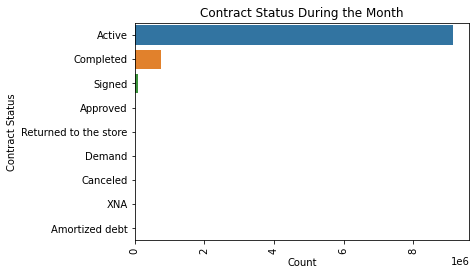

In [69]:
sns.countplot(y='NAME_CONTRACT_STATUS', data=cashBalDF)
plt.title('Contract Status During the Month')
plt.ylabel("Contract Status")
plt.xlabel("Count")
plt.xticks(rotation=90);

## Bureau Dataset  - Exploration

In [70]:
bureauDF.describe() #numerical only features

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [71]:
bureauDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


### Unique Values in Columns with Object Type

In [72]:
bureauDF.select_dtypes('object').apply(pd.Series.nunique, axis=0)

CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

### Missing Data

In [73]:
percent = (bureauDF.isnull().sum()/bureauDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = bureauDF.isna().sum().sort_values(ascending = False)
missing_bureau_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Bureau Missing Count"])
missing_bureau_data.head(20)

,Percent,Bureau Missing Count
AMT_ANNUITY,71.47,1226791
AMT_CREDIT_MAX_OVERDUE,65.51,1124488
DAYS_ENDDATE_FACT,36.92,633653
AMT_CREDIT_SUM_LIMIT,34.48,591780
AMT_CREDIT_SUM_DEBT,15.01,257669
DAYS_CREDIT_ENDDATE,6.15,105553
AMT_CREDIT_SUM,0.00,13
CREDIT_ACTIVE,0.00,0
CREDIT_CURRENCY,0.00,0
DAYS_CREDIT,0.00,0


### Status of the Credit in Bureaus

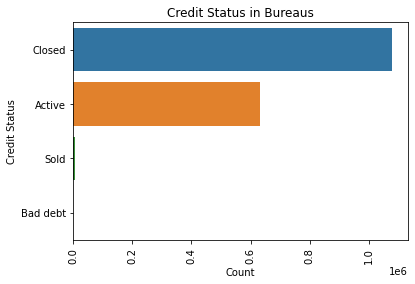

In [74]:
sns.countplot(y='CREDIT_ACTIVE', data=bureauDF)
plt.title('Credit Status in Bureaus')
plt.ylabel("Credit Status")
plt.xlabel("Count")
plt.xticks(rotation=90);

### Credit Type in Bureaus

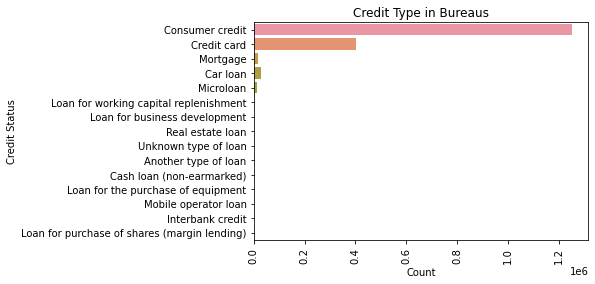

In [75]:
sns.countplot(y='CREDIT_TYPE', data=bureauDF)
plt.title('Credit Type in Bureaus')
plt.ylabel("Credit Status")
plt.xlabel("Count")
plt.xticks(rotation=90);

### Credit Amount Overdue

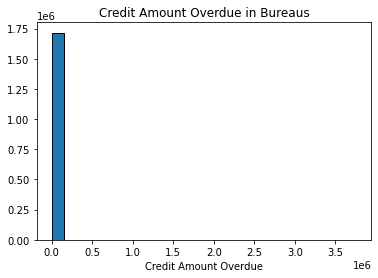

In [76]:
plt.hist(bureauDF['AMT_CREDIT_SUM_OVERDUE'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Credit Amount Overdue in Bureaus'); plt.xlabel('Credit Amount Overdue'); 

### Current Credit Amount in Bureaus

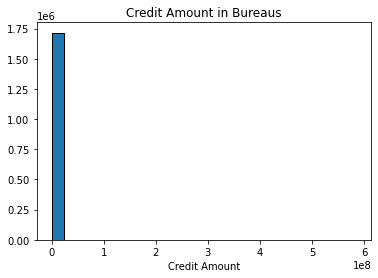

In [77]:
plt.hist(bureauDF['AMT_CREDIT_SUM'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Credit Amount in Bureaus'); plt.xlabel('Credit Amount'); 

## Bureau Balance Dataset  - Exploration

In [78]:
bureauBalDF.describe() #numerical only features

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


In [79]:
bureauBalDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


### Missing Data

In [80]:
percent = (bureauBalDF.isnull().sum()/bureauBalDF.isnull().count()*100).sort_values(ascending = False).round(2)
sum_missing = bureauBalDF.isna().sum().sort_values(ascending = False)
missing_bureaubal_data  = pd.concat([percent, sum_missing], axis=1, keys=['Percent', "Bureau Balance Count"])
missing_bureaubal_data.head(20)

,Percent,Bureau Balance Count
SK_ID_BUREAU,0.0,0
MONTHS_BALANCE,0.0,0
STATUS,0.0,0


### Bureau Balance Status

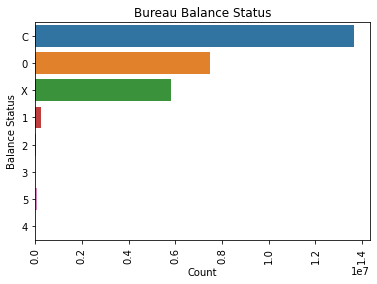

In [81]:
sns.countplot(y='STATUS', data=bureauBalDF)
plt.title('Bureau Balance Status')
plt.ylabel("Balance Status")
plt.xlabel("Count")
plt.xticks(rotation=90);

C means Closed, 0 means no DPD, X means Status Unknown; 1 means maximal did during month between 1-30; 2 means DPD 31-60; ....... 5 means DPD 120+ or sold or written off

### Number of Months Balance - Relative to App Date

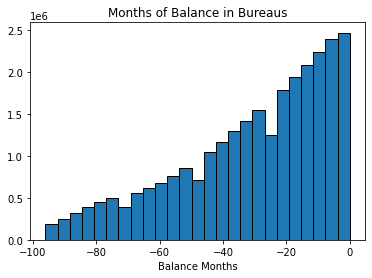

In [82]:
plt.hist(bureauBalDF['MONTHS_BALANCE'].dropna(), edgecolor = 'k', bins = 25)
plt.title('Months of Balance in Bureaus'); plt.xlabel('Balance Months'); 

# Processing of Subsets

## Previous Application - Merger

### POS Cash Balance

In [83]:
#Create feature list, excluding character features.
cash_bal_features = ['MONTHS_BALANCE', 'CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE', 'SK_DPD', 'SK_DPD_DEF']

cash_bal_df = FeaturesAggregater(grouping_feature = "SK_ID_PREV", features = cash_bal_features).transform(cashBalDF)

### Installment Payments

In [84]:
#Create feature list, excluding character features.
install_pay_features = ['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT', 
                        'AMT_INSTALMENT', 'AMT_PAYMENT']

install_pay_df = FeaturesAggregater(grouping_feature = "SK_ID_PREV", 
                                    features = install_pay_features).transform(installmentPayDF)

### Credit Card Balance

In [85]:
#Create feature list, excluding character features.
cc_bal_features = ['MONTHS_BALANCE', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 
                   'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 
                   'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 
                   'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 
                   'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 
                   'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD', 'SK_DPD_DEF']

cc_bal_df = FeaturesAggregater(grouping_feature = "SK_ID_PREV", features = cc_bal_features).transform(creditCardBalDF)

### Join Together

In [86]:
merge_all_data = True

if merge_all_data:
    prev_apps_all_df = previousAppDF.merge(cash_bal_df, how='left', on='SK_ID_PREV')
    prev_apps_all_df = prev_apps_all_df.merge(install_pay_df, how='left', on='SK_ID_PREV')
    prev_apps_all_df = prev_apps_all_df.merge(cc_bal_df, how='left', on='SK_ID_PREV')

In [87]:
#This should be true
len(prev_apps_all_df) == len(previousAppDF)

True

## Bureau - Merger

### Bureau Balance

In [88]:
#Create feature list, excluding character features.
bur_bal_features = ['MONTHS_BALANCE']

bur_bal_df = FeaturesAggregater(grouping_feature = "SK_ID_BUREAU", features = bur_bal_features).transform(bureauBalDF)

### Join Together

In [89]:
merge_all_data = True

if merge_all_data:
    bureau_all_df = bureauDF.merge(bur_bal_df, how='left', on='SK_ID_BUREAU')

In [90]:
#This should be true
len(bureau_all_df) == len(bureauDF)

True

## Application - Merger

### POS Cash Balance

In [91]:
cash_bal_df_2 = FeaturesAggregater(grouping_feature = "SK_ID_CURR", features = cash_bal_features).transform(cashBalDF)

### Installment Payments

In [92]:
install_pay_df_2 = FeaturesAggregater(grouping_feature = "SK_ID_CURR", 
                                    features = install_pay_features).transform(installmentPayDF)

### Credit Card Balance

In [93]:
cc_bal_df_2 = FeaturesAggregater(grouping_feature = "SK_ID_CURR", features = cc_bal_features).transform(creditCardBalDF)

### Previous Application

In [94]:
#Create feature list, excluding character features.
prevapp_features = ['AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'HOUR_APPR_PROCESS_START',
       'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'SELLERPLACE_AREA',
       'CNT_PAYMENT', 
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'MONTHS_BALANCE_median_x', 
       'CNT_INSTALMENT_median', 'CNT_INSTALMENT_FUTURE_median', 'SK_DPD_median_x', 'SK_DPD_DEF_median_x', 
       'NUM_INSTALMENT_VERSION_median', 'NUM_INSTALMENT_NUMBER_median', 'DAYS_INSTALMENT_median', 
       'DAYS_ENTRY_PAYMENT_median', 'AMT_INSTALMENT_median', 'AMT_PAYMENT_median', 'MONTHS_BALANCE_median_y',
       'AMT_BALANCE_median', 'AMT_CREDIT_LIMIT_ACTUAL_median', 'AMT_DRAWINGS_ATM_CURRENT_median', 
       'AMT_DRAWINGS_CURRENT_median', 'AMT_DRAWINGS_OTHER_CURRENT_median', 'AMT_DRAWINGS_POS_CURRENT_median', 
       'AMT_INST_MIN_REGULARITY_median', 'AMT_PAYMENT_CURRENT_median', 'AMT_PAYMENT_TOTAL_CURRENT_median', 
       'AMT_RECEIVABLE_PRINCIPAL_median', 'AMT_RECIVABLE_median', 'AMT_TOTAL_RECEIVABLE_median', 
       'CNT_DRAWINGS_ATM_CURRENT_median', 'CNT_DRAWINGS_CURRENT_median', 'CNT_DRAWINGS_OTHER_CURRENT_median', 
       'CNT_DRAWINGS_POS_CURRENT_median', 'CNT_INSTALMENT_MATURE_CUM_median', 'SK_DPD_median_y', 'SK_DPD_DEF_median_y']

prev_app_all_df_2 = FeaturesAggregater(grouping_feature = "SK_ID_CURR", 
                                       features = prevapp_features).transform(prev_apps_all_df)

### Bureau

In [95]:
#Create feature list, excluding character features.
bur_features = ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 
                'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 
                'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 
                'MONTHS_BALANCE_median'
                ]

bureau_all_df_2 = FeaturesAggregater(grouping_feature = "SK_ID_CURR", 
                                       features = bur_features).transform(bureau_all_df)

### Join Together

In [96]:
# Train Dataset
merge_all_data = True

if merge_all_data:
    apps_train_all_data_df = appTrainDF.merge(cash_bal_df_2, how='left', on='SK_ID_CURR')
    apps_train_all_data_df = apps_train_all_data_df.merge(install_pay_df_2, how='left', on='SK_ID_CURR')
    apps_train_all_data_df = apps_train_all_data_df.merge(cc_bal_df_2, how='left', on='SK_ID_CURR')
    apps_train_all_data_df = apps_train_all_data_df.merge(prev_app_all_df_2, how='left', on='SK_ID_CURR')
    apps_train_all_data_df = apps_train_all_data_df.merge(bureau_all_df_2, how='left', on='SK_ID_CURR')

In [97]:
#This should be true
len(apps_train_all_data_df) == len(appTrainDF)

True

In [98]:
# Test Dataset
merge_all_data = True

if merge_all_data:
    apps_test_all_data_df = appTestDF.merge(cash_bal_df_2, how='left', on='SK_ID_CURR')
    apps_test_all_data_df = apps_test_all_data_df.merge(install_pay_df_2, how='left', on='SK_ID_CURR')
    apps_test_all_data_df = apps_test_all_data_df.merge(cc_bal_df_2, how='left', on='SK_ID_CURR')
    apps_test_all_data_df = apps_test_all_data_df.merge(prev_app_all_df_2, how='left', on='SK_ID_CURR')
    apps_test_all_data_df = apps_test_all_data_df.merge(bureau_all_df_2, how='left', on='SK_ID_CURR')

In [99]:
#This should be true
len(apps_test_all_data_df) == len(appTestDF)

True

# Additional EDA With New Features

## Amount Balance

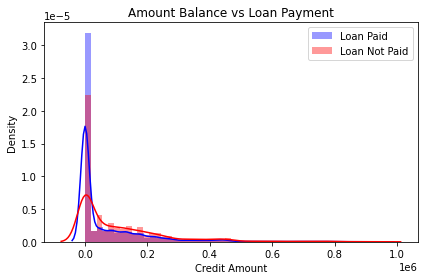

In [100]:
plt.figure()
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 0, 'AMT_BALANCE_median_median'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 1, 'AMT_BALANCE_median_median'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Amount Balance vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

## Days Credit

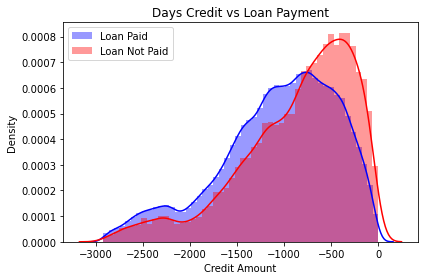

In [101]:
plt.figure()
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 0, 'DAYS_CREDIT_median'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 1, 'DAYS_CREDIT_median'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Days Credit vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

## Months Balance

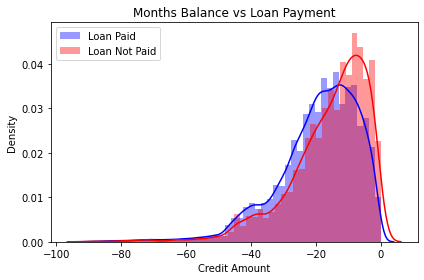

In [102]:
plt.figure()
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 0, 'MONTHS_BALANCE_median_median'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 1, 'MONTHS_BALANCE_median_median'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Months Balance vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

## Count of Drawings ATM

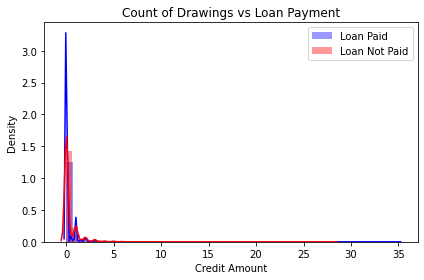

In [103]:
plt.figure()
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 0, 'CNT_DRAWINGS_ATM_CURRENT_median'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 1, 'CNT_DRAWINGS_ATM_CURRENT_median'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Count of Drawings vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

## Minimum Installment Amount Regularity

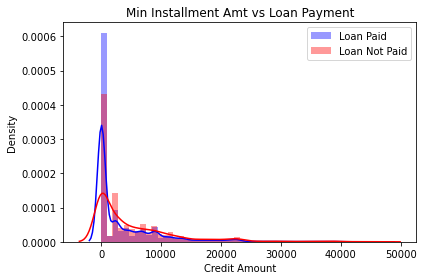

In [104]:
plt.figure()
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 0, 'AMT_INST_MIN_REGULARITY_median_median'], hist=True, color='blue', label = 'Loan Paid')
sns.distplot(apps_train_all_data_df.loc[apps_train_all_data_df['TARGET'] == 1, 'AMT_INST_MIN_REGULARITY_median_median'], hist=True, color='red', label = 'Loan Not Paid')
plt.xlabel('Credit Amount'); plt.ylabel('Density'); plt.title('Min Installment Amt vs Loan Payment'); plt.tight_layout(); plt.legend(); plt.show();

## Revised Correlation with TARGET column, using full dataset

In [105]:
correlations = apps_train_all_data_df.corr()['TARGET'].sort_values()

print('Most Positive Correlations with TARGET - Top 10:')
print(correlations.tail(10))

print('\nMost Negative Correlations with TARGET - Top 10:')
print(correlations.head(10))

Most Positive Correlations with TARGET - Top 10:
AMT_RECEIVABLE_PRINCIPAL_median_median    0.083894
AMT_RECIVABLE_median_median               0.084136
AMT_TOTAL_RECEIVABLE_median_median        0.084138
AMT_RECEIVABLE_PRINCIPAL_median           0.084473
AMT_RECIVABLE_median                      0.084657
AMT_TOTAL_RECEIVABLE_median               0.084668
AMT_BALANCE_median_median                 0.084782
AMT_BALANCE_median                        0.085281
DAYS_CREDIT_median                        0.085414
TARGET                                    1.000000
Name: TARGET, dtype: float64

Most Negative Correlations with TARGET - Top 10:
EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645
DAYS_FIRST_DRAWING_median    -0.038551
REGION_POPU

## Correlation Observations

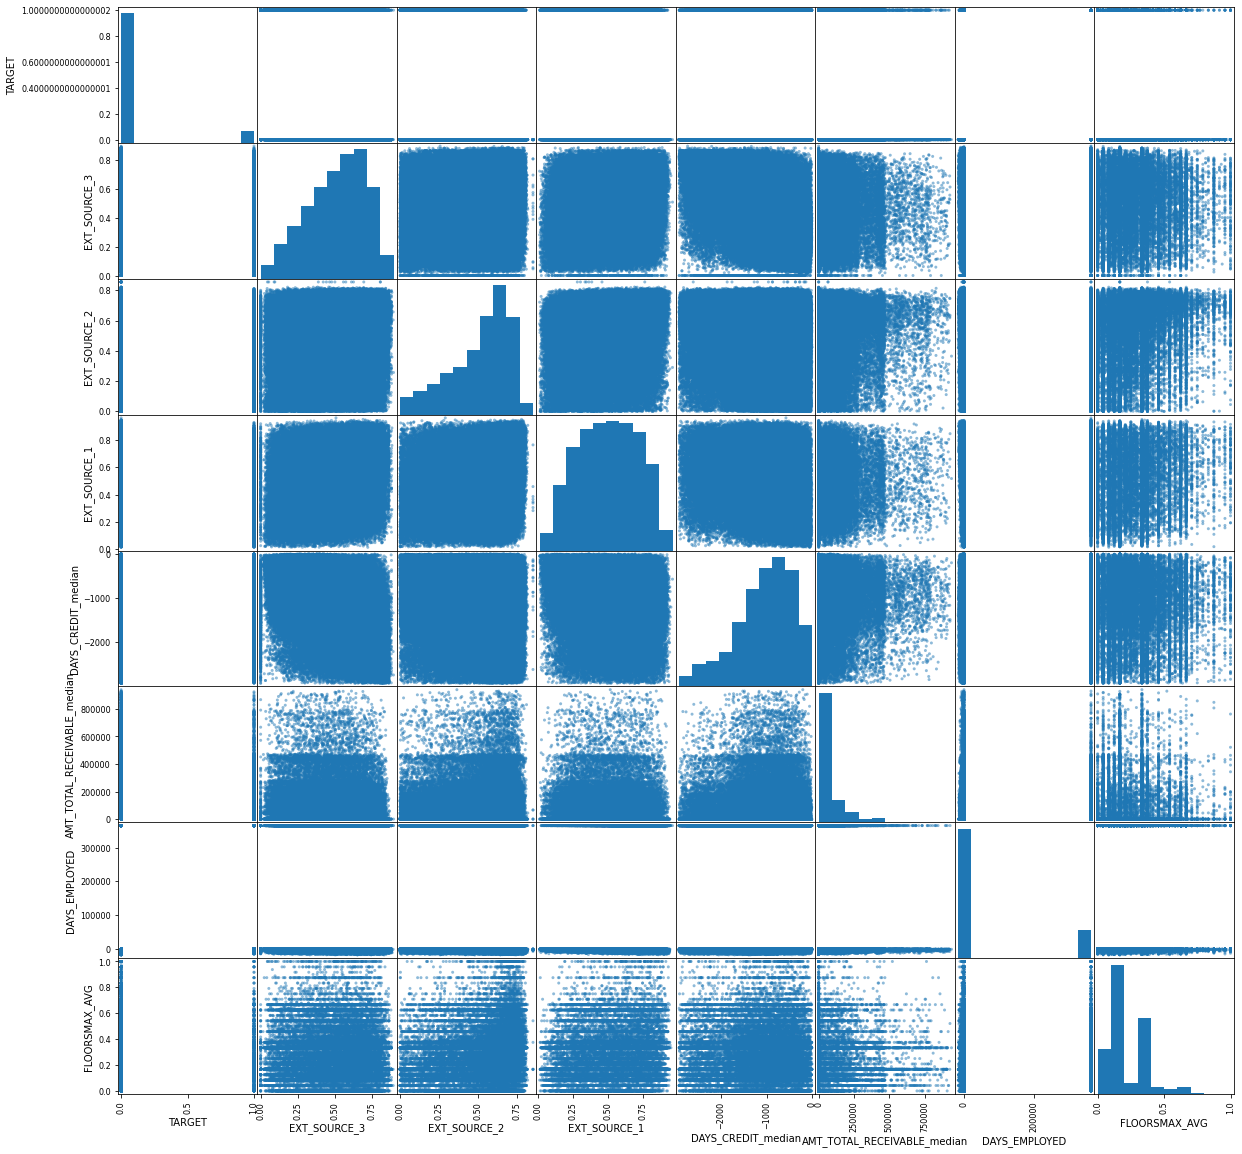

In [106]:
# Some top correlated inputs with TARGET
attributes = ["TARGET", "EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1", "DAYS_CREDIT_median", "AMT_TOTAL_RECEIVABLE_median", "DAYS_EMPLOYED", "FLOORSMAX_AVG"]
scatter_matrix(apps_train_all_data_df[attributes], figsize=(20, 20));

## Correlation - Heat Map

<AxesSubplot:>

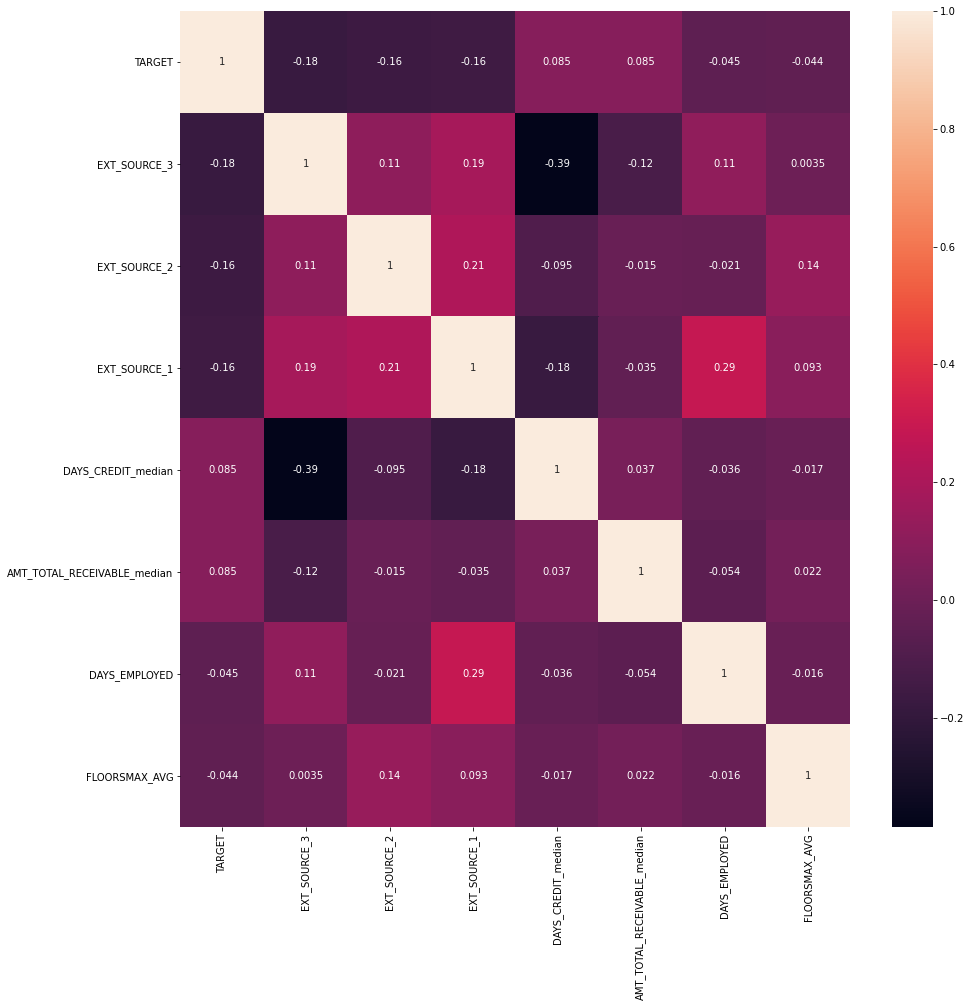

In [107]:
# Correlation Heat Map for Some Top Features
fig, ax = plt.subplots(figsize=(15,15))  
sns.heatmap(
    apps_train_all_data_df.loc[:, ["TARGET", "EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1", "DAYS_CREDIT_median", "AMT_TOTAL_RECEIVABLE_median", "DAYS_EMPLOYED", "FLOORSMAX_AVG"]].corr(),
    annot=True
)

## Pairplot

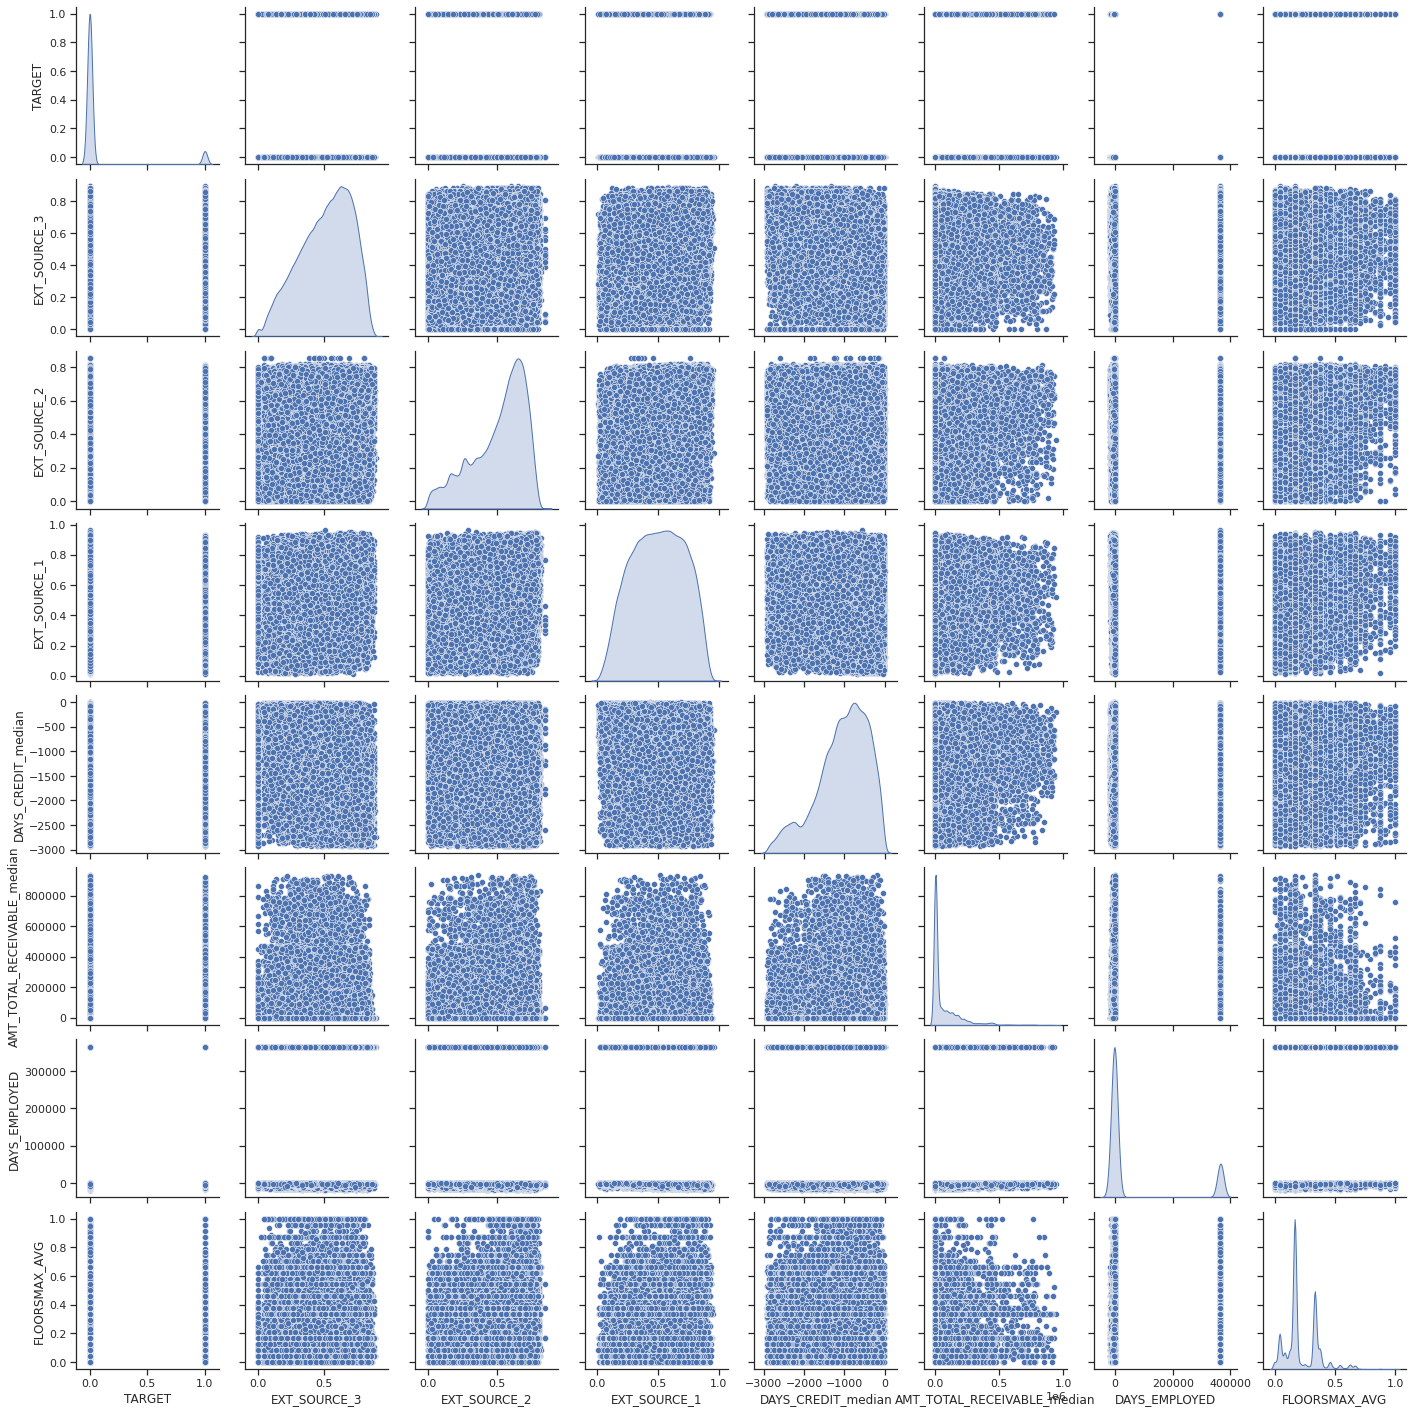

In [108]:
sns.set(style="ticks", color_codes=True) 
g = sns.pairplot(apps_train_all_data_df, vars=["TARGET", "EXT_SOURCE_3", "EXT_SOURCE_2", "EXT_SOURCE_1", "DAYS_CREDIT_median", 
                                               "AMT_TOTAL_RECEIVABLE_median", "DAYS_EMPLOYED", "FLOORSMAX_AVG"], diag_kind="kde")
g.fig.set_size_inches(20, 20)
plt.show()

## Data Cleanup/Setup

In [110]:
# delete this section if base model is to be run only with Application dataset

# delete objects no longer needed for memory
import gc
gc.enable()
del appTestDF
del appTrainDF
gc.collect()

appTrainDF = apps_train_all_data_df
appTestDF = apps_test_all_data_df

# Modeling

## Modeling Method

The **initial baseline** model will be fit only with the application data set to predict credit default.

**Data:**
* Loan application data

**Validation strategy:**
* Data is split such that 80% is in training data and 20% is held out in testing data
* 5 fold cross validation will be used for tuning and estimating accuracy before evaluating on test data - see tuning section below.

**Features:** 
* All numeric and categorical

**Data preprocessing:**
* Numeric features: missing features imputed with median then all numeric features are standardized
* Categorical features: missing features filled with '' then all categorical features are one hot encoded

**Tuning strategy:**
* The hyperparameter tuning will be completed using a random 10% of the training data. The hyperparameters will be chosen based on the subset generating the highest 5 fold validation area under the roc curve.

* We will use the remaining 90% of the training data to perform 5 fold cross validation with the best hyperparameters from the tuning process to gather estimates of how the model will perform on unseen data.

**Algorithm:** 
* Elastic Net Logistic Regression

**Evaluation:**

* Main metric to optimize: Area under ROC curve
* Other metrics to evaluate: precision, recall, f1 score, classification accuracy, confusion matrix

## Split Data

In [111]:
# assign the input and response features
X = appTrainDF.drop(['SK_ID_CURR', 'TARGET'], axis = 1)
y = appTrainDF['TARGET']

In [112]:
# split data such that 80% in training and 20% in test
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

x_train.shape

(246008, 214)

A standard 4 Core and 16 GB RAM does not have enough compute power to train a model of this size. Thus we will do an additional split with the training data in order for performing hyperparameter tuning. The hyperparameter tuning will be completed using a random 10% of the training data. The hyperparameters will be chosen based on the subset generating the highest 5 fold validation area under the roc curve. We will use the remaining 90% of the training data to perform 5 fold cross validation with the best hyperparameters from the tuning process to gather estimates of how the model will perform on unseen data.

In [113]:
# split data such that 10% is used for tuning, other 90% used for cross fold validation with best hyperparameters
x_sample_10, x_sample_90, y_sample_10, y_sample_90 = train_test_split(x_train, y_train, stratify=y_train, test_size=.9, random_state=42)

x_sample_10.shape

(24600, 214)

## Pipelines

### Setup Logistic Pipeline

In [114]:
# create pipeline for numeric features
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

# create pipeline for categorical features
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value="Unknown")),
        ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
    ])


In [115]:
# test the transformer

# specify the numeric features
numerical_features = ['CNT_CHILDREN',
                      'AMT_INCOME_TOTAL',
                      'AMT_CREDIT',
                      'AMT_ANNUITY',
                      'AMT_GOODS_PRICE',
                      'REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH',
                      'DAYS_EMPLOYED',
                      'DAYS_REGISTRATION',
                      'DAYS_ID_PUBLISH',
                      'OWN_CAR_AGE',
                      'FLAG_MOBIL',
                      'FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE',
                      'FLAG_CONT_MOBILE',
                      'FLAG_PHONE',
                      'FLAG_EMAIL',
                      'CNT_FAM_MEMBERS',
                      'REG_REGION_NOT_LIVE_REGION',
                      'REG_REGION_NOT_WORK_REGION',
                      'LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY',
                      'REG_CITY_NOT_WORK_CITY',
                      'LIVE_CITY_NOT_WORK_CITY',
                      'EXT_SOURCE_1',
                      'EXT_SOURCE_2',
                      'EXT_SOURCE_3',
                      'APARTMENTS_AVG',
                      'BASEMENTAREA_AVG',
                      'YEARS_BEGINEXPLUATATION_AVG',
                      'YEARS_BUILD_AVG',
                      'COMMONAREA_AVG',
                      'ELEVATORS_AVG',
                      'ENTRANCES_AVG',
                      'FLOORSMAX_AVG',
                      'FLOORSMIN_AVG',
                      'LANDAREA_AVG',
                      'LIVINGAPARTMENTS_AVG',
                      'LIVINGAREA_AVG',
                      'NONLIVINGAPARTMENTS_AVG',
                      'NONLIVINGAREA_AVG',
                      'APARTMENTS_MODE',
                      'BASEMENTAREA_MODE',
                      'YEARS_BEGINEXPLUATATION_MODE',
                      'YEARS_BUILD_MODE',
                      'COMMONAREA_MODE',
                      'ELEVATORS_MODE',
                      'ENTRANCES_MODE',
                      'FLOORSMAX_MODE',
                      'FLOORSMIN_MODE',
                      'LANDAREA_MODE',
                      'LIVINGAPARTMENTS_MODE',
                      'LIVINGAREA_MODE',
                      'NONLIVINGAPARTMENTS_MODE',
                      'NONLIVINGAREA_MODE',
                      'APARTMENTS_MEDI',
                      'BASEMENTAREA_MEDI',
                      'YEARS_BEGINEXPLUATATION_MEDI',
                      'YEARS_BUILD_MEDI',
                      'COMMONAREA_MEDI',
                      'ELEVATORS_MEDI',
                      'ENTRANCES_MEDI',
                      'FLOORSMAX_MEDI',
                      'FLOORSMIN_MEDI',
                      'LANDAREA_MEDI',
                      'LIVINGAPARTMENTS_MEDI',
                      'LIVINGAREA_MEDI',
                      'NONLIVINGAPARTMENTS_MEDI',
                      'NONLIVINGAREA_MEDI',
                      'TOTALAREA_MODE',
                      'OBS_30_CNT_SOCIAL_CIRCLE',
                      'DEF_30_CNT_SOCIAL_CIRCLE',
                      'OBS_60_CNT_SOCIAL_CIRCLE',
                      'DEF_60_CNT_SOCIAL_CIRCLE',
                      'DAYS_LAST_PHONE_CHANGE',
                      'FLAG_DOCUMENT_2',
                      'FLAG_DOCUMENT_3',
                      'FLAG_DOCUMENT_4',
                      'FLAG_DOCUMENT_5',
                      'FLAG_DOCUMENT_6',
                      'FLAG_DOCUMENT_7',
                      'FLAG_DOCUMENT_8',
                      'FLAG_DOCUMENT_9',
                      'FLAG_DOCUMENT_10',
                      'FLAG_DOCUMENT_11',
                      'FLAG_DOCUMENT_12',
                      'FLAG_DOCUMENT_13',
                      'FLAG_DOCUMENT_14',
                      'FLAG_DOCUMENT_15',
                      'FLAG_DOCUMENT_16',
                      'FLAG_DOCUMENT_17',
                      'FLAG_DOCUMENT_18',
                      'FLAG_DOCUMENT_19',
                      'FLAG_DOCUMENT_20',
                      'FLAG_DOCUMENT_21',
                      'AMT_REQ_CREDIT_BUREAU_HOUR',
                      'AMT_REQ_CREDIT_BUREAU_DAY',
                      'AMT_REQ_CREDIT_BUREAU_WEEK',
                      'AMT_REQ_CREDIT_BUREAU_MON',
                      'AMT_REQ_CREDIT_BUREAU_QRT',
                      'AMT_REQ_CREDIT_BUREAU_YEAR',
# new set of features from subsets                  
                      'MONTHS_BALANCE_median_x',
                      'CNT_INSTALMENT_median',
                      'CNT_INSTALMENT_FUTURE_median',
                      'SK_DPD_median_x',
                      'SK_DPD_DEF_median_x',
                      'NUM_INSTALMENT_VERSION_median',
                      'NUM_INSTALMENT_NUMBER_median',
                      'DAYS_INSTALMENT_median',
                      'DAYS_ENTRY_PAYMENT_median',
                      'AMT_INSTALMENT_median',
                      'AMT_PAYMENT_median',
                      'MONTHS_BALANCE_median_y',
                      'AMT_BALANCE_median',
                      'AMT_CREDIT_LIMIT_ACTUAL_median',
                      'AMT_DRAWINGS_ATM_CURRENT_median',
                      'AMT_DRAWINGS_CURRENT_median',
                      'AMT_DRAWINGS_OTHER_CURRENT_median',
                      'AMT_DRAWINGS_POS_CURRENT_median',
                      'AMT_INST_MIN_REGULARITY_median',
                      'AMT_PAYMENT_CURRENT_median',
                      'AMT_PAYMENT_TOTAL_CURRENT_median',
                      'AMT_RECEIVABLE_PRINCIPAL_median',
                      'AMT_RECIVABLE_median',
                      'AMT_TOTAL_RECEIVABLE_median',
                      'CNT_DRAWINGS_ATM_CURRENT_median',
                      'CNT_DRAWINGS_CURRENT_median',
                      'CNT_DRAWINGS_OTHER_CURRENT_median',
                      'CNT_DRAWINGS_POS_CURRENT_median',
                      'CNT_INSTALMENT_MATURE_CUM_median',
                      'SK_DPD_median_y',
                      'SK_DPD_DEF_median_y',
                      'AMT_ANNUITY_median_x',
                      'AMT_APPLICATION_median',
                      'AMT_CREDIT_median',
                      'AMT_DOWN_PAYMENT_median',
                      'AMT_GOODS_PRICE_median',
                      'HOUR_APPR_PROCESS_START_median',
                      'NFLAG_LAST_APPL_IN_DAY_median',
                      'RATE_DOWN_PAYMENT_median',
                      'RATE_INTEREST_PRIMARY_median',
                      'RATE_INTEREST_PRIVILEGED_median',
                      'DAYS_DECISION_median',
                      'SELLERPLACE_AREA_median',
                      'CNT_PAYMENT_median',
                      'DAYS_FIRST_DRAWING_median',
                      'DAYS_FIRST_DUE_median',
                      'DAYS_LAST_DUE_1ST_VERSION_median',
                      'DAYS_LAST_DUE_median',
                      'DAYS_TERMINATION_median',
                      'NFLAG_INSURED_ON_APPROVAL_median',
                      'MONTHS_BALANCE_median_x_median',
                      'CNT_INSTALMENT_median_median',
                      'CNT_INSTALMENT_FUTURE_median_median',
                      'SK_DPD_median_x_median',
                      'SK_DPD_DEF_median_x_median',
                      'NUM_INSTALMENT_VERSION_median_median',
                      'NUM_INSTALMENT_NUMBER_median_median',
                      'DAYS_INSTALMENT_median_median',
                      'DAYS_ENTRY_PAYMENT_median_median',
                      'AMT_INSTALMENT_median_median',
                      'AMT_PAYMENT_median_median',
                      'MONTHS_BALANCE_median_y_median',
                      'AMT_BALANCE_median_median',
                      'AMT_CREDIT_LIMIT_ACTUAL_median_median',
                      'AMT_DRAWINGS_ATM_CURRENT_median_median',
                      'AMT_DRAWINGS_CURRENT_median_median',
                      'AMT_DRAWINGS_OTHER_CURRENT_median_median',
                      'AMT_DRAWINGS_POS_CURRENT_median_median',
                      'AMT_INST_MIN_REGULARITY_median_median',
                      'AMT_PAYMENT_CURRENT_median_median',
                      'AMT_PAYMENT_TOTAL_CURRENT_median_median',
                      'AMT_RECEIVABLE_PRINCIPAL_median_median',
                      'AMT_RECIVABLE_median_median',
                      'AMT_TOTAL_RECEIVABLE_median_median',
                      'CNT_DRAWINGS_ATM_CURRENT_median_median',
                      'CNT_DRAWINGS_CURRENT_median_median',
                      'CNT_DRAWINGS_OTHER_CURRENT_median_median',
                      'CNT_DRAWINGS_POS_CURRENT_median_median',
                      'CNT_INSTALMENT_MATURE_CUM_median_median',
                      'SK_DPD_median_y_median',
                      'SK_DPD_DEF_median_y_median',
                      'DAYS_CREDIT_median',
                      'CREDIT_DAY_OVERDUE_median',
                      'DAYS_CREDIT_ENDDATE_median',
                      'DAYS_ENDDATE_FACT_median',
                      'AMT_CREDIT_MAX_OVERDUE_median',
                      'CNT_CREDIT_PROLONG_median',
                      'AMT_CREDIT_SUM_median',
                      'AMT_CREDIT_SUM_DEBT_median',
                      'AMT_CREDIT_SUM_LIMIT_median',
                      'AMT_CREDIT_SUM_OVERDUE_median',
                      'DAYS_CREDIT_UPDATE_median',
                      'AMT_ANNUITY_median_y',
                      'MONTHS_BALANCE_median_median'                      
                     ]

# specify the categorical features
categorical_features = ['NAME_CONTRACT_TYPE',
                        'CODE_GENDER',
                        'FLAG_OWN_CAR',
                        'FLAG_OWN_REALTY',
                        'NAME_TYPE_SUITE',
                        'NAME_INCOME_TYPE',
                        'NAME_EDUCATION_TYPE',
                        'NAME_FAMILY_STATUS',
                        'NAME_HOUSING_TYPE',
                        'OCCUPATION_TYPE',
                        'WEEKDAY_APPR_PROCESS_START',
                        'ORGANIZATION_TYPE',
                        'FONDKAPREMONT_MODE',
                        'HOUSETYPE_MODE',
                        'WALLSMATERIAL_MODE',
                        'EMERGENCYSTATE_MODE',
                        'HOUR_APPR_PROCESS_START',
                        'REGION_RATING_CLIENT',
                        'REGION_RATING_CLIENT_W_CITY']

# specify the column transformer for numeric and categorical features
logistic_data_pipeline = ColumnTransformer(
    [("num_pipeline", num_pipeline, numerical_features),
    ("cat_pipeline", cat_pipeline, categorical_features)],
    remainder='passthrough')


X_train_transformed = logistic_data_pipeline.fit_transform(x_train)

column_names = numerical_features  + \
               list(logistic_data_pipeline.transformers_[1][1].named_steps["ohe"].get_feature_names(categorical_features))

display(pd.DataFrame(X_train_transformed,  columns=column_names).head())

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,MONTHS_BALANCE_median_x,CNT_INSTALMENT_median,CNT_INSTALMENT_FUTURE_median,SK_DPD_median_x,SK_DPD_DEF_median_x,NUM_INSTALMENT_VERSION_median,NUM_INSTALMENT_NUMBER_median,DAYS_INSTALMENT_median,DAYS_ENTRY_PAYMENT_median,AMT_INSTALMENT_median,AMT_PAYMENT_median,MONTHS_BALANCE_median_y,AMT_BALANCE_median,AMT_CREDIT_LIMIT_ACTUAL_median,AMT_DRAWINGS_ATM_CURRENT_median,AMT_DRAWINGS_CURRENT_median,AMT_DRAWINGS_OTHER_CURRENT_median,AMT_DRAWINGS_POS_CURRENT_median,AMT_INST_MIN_REGULARITY_median,AMT_PAYMENT_CURRENT_median,AMT_PAYMENT_TOTAL_CURRENT_median,AMT_RECEIVABLE_PRINCIPAL_median,AMT_RECIVABLE_median,AMT_TOTAL_RECEIVABLE_median,CNT_DRAWINGS_ATM_CURRENT_median,CNT_DRAWINGS_CURRENT_median,CNT_DRAWINGS_OTHER_CURRENT_median,CNT_DRAWINGS_POS_CURRENT_median,CNT_INSTALMENT_MATURE_CUM_median,SK_DPD_median_y,SK_DPD_DEF_median_y,AMT_ANNUITY_median_x,AMT_APPLICATION_median,AMT_CREDIT_median,AMT_DOWN_PAYMENT_median,AMT_GOODS_PRICE_median,HOUR_APPR_PROCESS_START_median,NFLAG_LAST_APPL_IN_DAY_median,RATE_DOWN_PAYMENT_median,RATE_INTEREST_PRIMARY_median,RATE_INTEREST_PRIVILEGED_median,DAYS_DECISION_median,SELLERPLACE_AREA_median,CNT_PAYMENT_median,DAYS_FIRST_DRAWING_median,DAYS_FIRST_DUE_median,DAYS_LAST_DUE_1ST_VERSION_median,DAYS_LAST_DUE_median,DAYS_TERMINATION_median,NFLAG_INSURED_ON_APPROVAL_median,MONTHS_BALANCE_median_x_median,CNT_INSTALMENT_median_median,CNT_INSTALMENT_FUTURE_median_median,SK_DPD_median_x_median,SK_DPD_DEF_median_x_median,NUM_INSTALMENT_VERSION_median_median,NUM_INSTALMENT_NUMBER_median_median,DAYS_INSTALMENT_median_median,DAYS_ENTRY_PAYMENT_median_median,AMT_INSTALMENT_median_median,AMT_PAYMENT_median_median,MONTHS_BALANCE_median_y_median,AMT_BALANCE_median_median,AMT_CREDIT_LIMIT_ACTUAL_median_median,AMT_DRAWINGS_ATM_CURRENT_median_median,AMT_DRAWINGS_CURRENT_median_median,AMT_DRAWINGS_OTHER_CURRENT_median_median,AMT_DRAWINGS_POS_CURRENT_median_median,AMT_INST_MIN_REGULARITY_median_median,AMT_PAYMENT_CURRENT_median_median,AMT_PAYMENT_TOTAL_CURRENT_median_median,AMT_RECEIVABLE_PRINCIPAL_median_median,AMT_RECIVABLE_median_median,AMT_TOTAL_RECEIVABLE_median_median,CNT_DRAWINGS_ATM_CURRENT_median_median,CNT_DRAWINGS_CURRENT_median_

In [116]:
X_train_transformed.shape

(246008, 371)

## Hyperparameter Tuning

### Candidate Parameters

In [117]:
# set your parameter grid
logistic_params= {'logistic__C': (100, 10, 1, 0.1, 0.01),
                  'logistic__l1_ratio': (0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.),
                 }

### Regularized Logistic Regression w/ all columns

In [118]:
# generate the pipeline
logistic_pipeline = Pipeline([
("preparation", logistic_data_pipeline),
("logistic", LogisticRegression(penalty='elasticnet', solver='saga'))
])

# set up cross validation grid search
logistic_grid_search = GridSearchCV(logistic_pipeline,
                                    param_grid=logistic_params,
                                    scoring='roc_auc',
                                    cv=5,
                                    n_jobs=-1,
                                    verbose=True)

# grid search on training data
logistic_grid_search.fit(x_sample_10, y_sample_10)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 275 out of 275 | elapsed:  9.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
                                         

In [119]:
# print grid search results
pd.concat([pd.DataFrame(logistic_grid_search.cv_results_["params"]),pd.DataFrame(logistic_grid_search.cv_results_["mean_test_score"], columns=["roc_auc"])],axis=1).sort_values(by='roc_auc', ascending=False)

,logistic__C,logistic__l1_ratio,roc_auc
43,0.10,1.0,0.736530
42,0.10,0.9,0.736508
41,0.10,0.8,0.736490
40,0.10,0.7,0.736422
39,0.10,0.6,0.736340
45,0.01,0.1,0.736256
38,0.10,0.5,0.736219
37,0.10,0.4,0.736139
36,0.10,0.3,0.736035
46,0.01,0.2,0.735972


In [120]:
# print the best parameters
logistic_grid_search.best_params_

{'logistic__C': 0.1, 'logistic__l1_ratio': 1.0}

In [121]:
# perform 5 fold cv with best hyperparameters
results = cross_val_score(logistic_grid_search.best_estimator_, 
                          x_sample_90, y_sample_90,
                          scoring='roc_auc',
                          cv=5,
                          n_jobs=-1)

# print grid search results
pd.DataFrame(results, columns=["roc_auc"])

,roc_auc
0,0.748885
1,0.757973
2,0.750524
3,0.758732
4,0.745551


In [122]:
# calculate mean out of sample cv train score 
logistic_train_mean_score = np.mean(results)

# print the mean out of sample cv train score
logistic_train_mean_score

0.7523328333208296

### Regularized Logistic Regression w/ Top 50 Most Important Columns

In [123]:
# get model coefficients
clf = logistic_grid_search.best_estimator_.named_steps['logistic']

# create table of feature importances
feature_importances = pd.concat([pd.DataFrame(column_names, columns = ['column names']), pd.DataFrame(clf.coef_[0], columns = ['coefficient']), pd.DataFrame(np.abs(clf.coef_[0]), columns = ['abs coefficient'])], axis=1).sort_values('abs coefficient', ascending=False)

feature_importances.head(50)

,column names,coefficient,abs coefficient
26,EXT_SOURCE_3,-0.405365,0.405365
197,CODE_GENDER_F,-0.385630,0.385630
25,EXT_SOURCE_2,-0.353512,0.353512
200,FLAG_OWN_CAR_N,-0.278846,0.278846
218,NAME_INCOME_TYPE_Unemployed,-0.253715,0.253715
334,WALLSMATERIAL_MODE_Panel,-0.238818,0.238818
228,NAME_FAMILY_STATUS_Single / not married,-0.226177,0.226177
195,NAME_CONTRACT_TYPE_Cash loans,-0.204170,0.204170
201,FLAG_OWN_CAR_Y,-0.201495,0.201495
323,FONDKAPREMONT_MODE_org spec account,-0.200302,0.200302


### Regularized Logistic Regression w/ PCA

In [124]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

### Regularized Logistic Regression w/ New Added Features from EDA

In [125]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

### Random Forest

In [126]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

### XGBoost

In [127]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

# Model Evaluation

In [128]:
# initialize the test results data frame
results = pd.DataFrame(columns=['model', 'Train Area under ROC', 'Test Area under ROC', 'Best Parameters'])

## Regularized Logistic Regression w/ all Columns

In [129]:
# generate predictions on test data
predictions = logistic_grid_search.best_estimator_.predict(x_test)

# calculate score on test predictions
test_score = accuracy_score(y_test, predictions)

# calculate roc_auc score on test predictions
test_roc_score = roc_auc_score(y_test, logistic_grid_search.best_estimator_.predict_proba(x_test)[:, 1])

# calculate classification report on test predictions
test_classification_report = classification_report(y_test, predictions)

# calculate confusion matrix on test predictions
test_confusion_matrix = confusion_matrix(y_test, predictions)

In [130]:
# display the classification report
print(test_classification_report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.46      0.01      0.03      4965

    accuracy                           0.92     61503
   macro avg       0.69      0.51      0.49     61503
weighted avg       0.88      0.92      0.88     61503



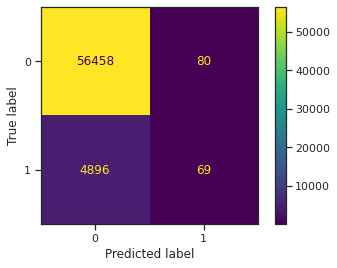

In [131]:
# plot confusion matrix
plot_confusion_matrix(logistic_grid_search, x_test, y_test)
plt.show()

In [132]:
# add accuracy score to results table
results.loc[0] = ['Logistic Regression', np.round(logistic_grid_search.best_score_*100, 2), np.round(test_roc_score*100, 2), logistic_grid_search.best_params_]

# show results
results

,model,Train Area under ROC,Test Area under ROC,Best Parameters
0,Logistic Regression,73.65,74.4,"{'logistic__C': 0.1, 'logistic__l1_ratio': 1.0}"


## Regularized Logistic Regression w/ top 50 most important columns

In [133]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

## Regularized Logistic Regression w/ PCA

In [134]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

## Regularized Logistic Regression w/ New Added Features from EDA

In [135]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

## Random Forest

In [136]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

## XGBoost

In [137]:
# PLACEHOLDER - PLEASE PICK THE NEXT MODEL UP HERE

# Execution Time

In [138]:
# temp time check - remove before submission
print("Start time is ", begin_time)
print("End time is ", datetime.datetime.now())
print("Run time is ", datetime.datetime.now() - begin_time)

Start time is  2021-04-16 09:54:03.810017
End time is  2021-04-16 10:17:14.068167
Run time is  0:23:10.258446
